In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib.pyplot import plot
from sklearn.preprocessing import MinMaxScaler
import datetime


# Any results you write to the current directory are saved as output.

The first step is to see the data we are processing. For that we can use the method describe that can summarize the dataset's info:

In [3]:
block= 'block_58'
original_data = pd.read_csv('daily_dataset/daily_dataset/{}.csv'.format(block))
original_data.describe()

,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min
count,30937.000000,30937.000000,30937.000000,30937.000000,30858.000000,30937.000000,30937.000000
mean,0.155948,0.212452,0.873458,47.840159,0.175351,10.170189,0.063817
std,0.096738,0.122306,0.605377,2.513634,0.128481,5.878187,0.050756
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.083000,0.118021,0.393000,48.000000,0.072106,5.644000,0.027000
50%,0.134500,0.193500,0.761000,48.000000,0.148121,9.273000,0.055000
75%,0.208500,0.283896,1.217000,48.000000,0.244847,13.605000,0.086000
max,1.353000,1.531771,5.903000,48.000000,1.397785,73.525000,1.040000


In [4]:
max_data = original_data.loc[original_data.groupby('LCLid').pipe(lambda group: group.energy_max.idxmax(skipna=True))][['LCLid','day','energy_max']]
min_data = original_data.loc[original_data.groupby('LCLid').pipe(lambda group: group.energy_max.idxmin(skipna=True))][['LCLid','day','energy_min']]
# original_data.describe()

data = original_data.groupby('LCLid').agg({'energy_median': ['mean'], 'energy_mean': ['mean'], 'energy_sum': ['sum']})
data = data.merge(max_data, left_on='LCLid', right_on='LCLid',suffixes=('_left', '_max'))
data = data.merge(min_data, left_on='LCLid', right_on='LCLid',suffixes=('_max', '_min'))
data['day_max'] = pd.to_datetime(data['day_max']).dt.dayofweek
data['day_min'] = pd.to_datetime(data['day_min']).dt.dayofweek

# data = pd.concat([data,pd.get_dummies(data['day_min'], prefix='day_min')],axis=1).drop(columns=['day_min'])
# data = pd.concat([data,pd.get_dummies(data['day_max'], prefix='day_max')],axis=1).drop(columns=['day_max'])
data['min_max_ratio'] = data.pipe(lambda group: group.energy_min/ group.energy_max)
# print(original_data[(original_data['LCLid']=='MAC000094')])


data.head()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/frame.py:9186: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left,1 on the right)
  return merge(


,LCLid,"(energy_median, mean)","(energy_mean, mean)","(energy_sum, sum)",day_max,energy_max,day_min,energy_min,min_max_ratio
0,MAC000094,0.178231,0.208458,8067.054,5,1.997,5,0.084,0.042063
1,MAC000097,0.282496,0.407007,15810.307,5,4.889,4,0.118,0.024136
2,MAC000151,0.062829,0.078041,3100.452,1,1.116,4,0.026,0.023297
3,MAC000157,0.213507,0.240548,9546.545,6,2.004,1,0.078,0.038922
4,MAC000352,0.152686,0.220642,7628.425,6,2.068,4,0.049,0.023694


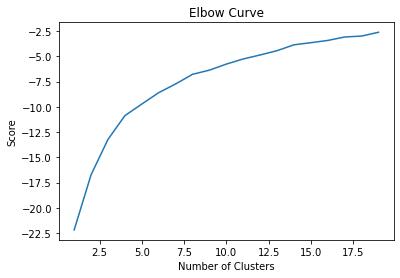

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(data.drop(columns=['LCLid']))

Nc = range(1, 20)
kmeans = [KMeans(n_clusters=i) for i in Nc]
score = [kmeans[i].fit(X).score(X) for i in range(len(kmeans))]

plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [6]:
kmeans = KMeans(n_clusters=4).fit(X)
centroids = kmeans.cluster_centers_
print(centroids)

[[0.3587994  0.38617733 0.3207827  0.90350877 0.24974547 0.62280702
  0.14636736 0.28502019]
 [0.71559959 0.82917252 0.69282468 0.83333333 0.63459009 0.75
  0.45389049 0.45559102]
 [0.1309129  0.1365006  0.09970932 0.37878788 0.147005   0.5
  0.12470527 0.31736533]
 [0.45457085 0.54020494 0.39987633 0.26190476 0.35065705 0.47619048
  0.17682174 0.32282266]]


In [11]:
clustered_data = pd.concat([data,pd.DataFrame(kmeans.predict(X))],axis=1).sort_values(by=[0])
clustered_data = clustered_data.rename(columns={0: 'Cluster'})
clustered_data.head()
clustered_data

,LCLid,"(energy_median, mean)","(energy_mean, mean)","(energy_sum, sum)",day_max,energy_max,day_min,energy_min,min_max_ratio,Cluster
0,MAC000094,0.178231,0.208458,8067.054000,5,1.997,5,0.084,0.042063,0
44,MAC004138,0.079524,0.107130,3332.758000,6,1.475,4,0.036,0.024407,0
42,MAC004049,0.087311,0.190483,5492.024000,4,3.237,5,0.027,0.008341,0
39,MAC003868,0.145399,0.222181,5232.583999,4,2.396,3,0.025,0.010434,0
37,MAC003831,0.142168,0.160626,3799.594000,6,1.116,4,0.096,0.086021,0
35,MAC003828,0.139435,0.218115,5160.315001,6,2.814,4,0.033,0.011727,0
34,MAC003819,0.150031,0.204224,4829.456000,5,2.049,3,0.055,0.026842,0
27,MAC002311,0.134146,0.161740,5216.378000,6,2.206,4,0.092,0.041704,0
48,MAC005533,0.198509,0.249600,8162.453001,6,2.266,0,0.006,0.002648,0
19,MAC001881,0.133239,0.166124,5023.827000,6,1.976,6,0.077,0.038968,0


In [66]:
DFS = pd.DataFrame(clustered_data)
DFS.to_csv(r'SUMclustersa.csv')


In [37]:
dc = pd.read_csv(r"SUMclusters.csv")
dc.head()

,Unnamed: 0,LCLid,Cluster
0,0,MAC000094,0
1,44,MAC004138,0
2,42,MAC004049,0
3,39,MAC003868,0
4,37,MAC003831,0


In [87]:
df = pd.read_csv('outputfiles2/energy.csv')
# hourly_data

In [124]:
energysum3 = dk.groupby('Cluster')[['LCLid']].count()
energysum3 = dk.merge(dk, on = ['LCLid'])
energysum3 = energysum3.reset_index()
energysum3

,index,index_x,day_x,LCLid,energy_sum_x,Cluster_x,index_y,day_y,energy_sum_y,Cluster_y
0,0,0,12/12/11,MAC000094,4.877,0,0,12/12/11,4.877,0
1,1,0,12/12/11,MAC000094,4.877,0,1,13/12/11,8.503,0
2,2,0,12/12/11,MAC000094,4.877,0,2,14/12/11,6.511,0
3,3,0,12/12/11,MAC000094,4.877,0,3,15/12/11,7.264,0
4,4,0,12/12/11,MAC000094,4.877,0,4,16/12/11,7.498,0
...,...,...,...,...,...,...,...,...,...,...
19637872,19637872,30936,28/02/14,MAC005543,0.373,0,30932,24/02/14,20.044,0
19637873,19637873,30936,28/02/14,MAC005543,0.373,0,30933,25/02/14,21.448,0
19637874,19637874,30936,28/02/14,MAC005543,0.373,0,30934,26/02/14,25.621,0
19637875,19637875,30936,28/02/14,MAC005543,0.373,0,30935,27/02/14,21.227,0


In [29]:
# housecount = df.groupby('Cluster','LCLid')
# housecount
# # housecount.rename(columns={"LCLid": "HouseCount"}, inplace=True)
# housecount

ValueError: No axis named LCLid for object type DataFrame

In [88]:
energysum = df.groupby('Cluster')[['energy_sum']].sum()
energysum = df.merge(dc, on = ['LCLid'])
energysum = energysum.reset_index()
# energysum['avg_energy'] =  energysum['energy_sum']/energysum['HouseCount']
# energysum

KeyError: 'Cluster'

In [40]:
energysum
DFS1= pd.DataFrame(energysum)
DFS1.to_csv(r'clusters.csv')

In [69]:
dk = pd.read_csv(r"clusters.csv")
dk.head()
clus1= dk[dk.Cluster==0]
clus2= dk[dk.Cluster==1]
clus3= dk[dk.Cluster==2]
clus1.head()
# energysum['avg_energy'] =  energysum['energy_sum']/energysum['HouseCount']

,index,day,LCLid,energy_sum,Cluster
0,0,12/12/11,MAC000094,4.877,0
1,1,13/12/11,MAC000094,8.503,0
2,2,14/12/11,MAC000094,6.511,0
3,3,15/12/11,MAC000094,7.264,0
4,4,16/12/11,MAC000094,7.498,0


In [132]:
energysum3 = dk.groupby('Cluster')[['LCLid']].nunique()
energysum3.rename(columns={"LCLid": "HouseCount"}, inplace=True)
energysum3

,HouseCount
Cluster,
0,19
1,6
2,11
3,14


In [91]:
energysum = dk.groupby(['Cluster','day'])[['energy_sum']].sum()
# energysum = dk.merge(dc, on = ['LCLid'])
energysum = energysum.reset_index()
energysum

,Cluster,day,energy_sum
0,0,1/01/12,17.810
1,0,1/01/13,228.399
2,0,1/01/14,206.847
3,0,1/02/12,20.119
4,0,1/02/13,198.943
...,...,...,...
3220,3,9/10/13,142.968
3221,3,9/11/12,198.373
3222,3,9/11/13,161.994
3223,3,9/12/12,223.172


In [73]:
housecount = dk.groupby(['Cluster','day'])[['LCLid']].count()
housecount.rename(columns={"LCLid": "HouseCount"}, inplace=True)
housecount

HouseCount
Cluster day                
0       1/01/12           2
        1/01/13          19
        1/01/14          19
        1/02/12           2
        1/02/13          19
...                     ...
3       9/10/13          13
        9/11/12          14
        9/11/13          13
        9/12/12          14
        9/12/13          13

[3225 rows x 1 columns]

In [94]:
newplots = dk.merge(housecount, on = ['Cluster','day'])
newplots.head()

newplots1 = newplots.merge(energysum, on = ['Cluster','day'])
newplots1.head()

,index,day,LCLid,energy_sum_x,Cluster,HouseCount,energy_sum_y
0,0,12/12/11,MAC000094,4.877,0,2,18.242
1,2467,12/12/11,MAC000157,13.365,0,2,18.242
2,1,13/12/11,MAC000094,8.503,0,2,21.355
3,2468,13/12/11,MAC000157,12.852,0,2,21.355
4,2,14/12/11,MAC000094,6.511,0,2,20.614


In [95]:
newplots1['avg_energy'] =  newplots1['energy_sum_y']/newplots1['HouseCount']
newplots1

,index,day,LCLid,energy_sum_x,Cluster,HouseCount,energy_sum_y,avg_energy
0,0,12/12/11,MAC000094,4.877,0,2,18.242,9.1210
1,2467,12/12/11,MAC000157,13.365,0,2,18.242,9.1210
2,1,13/12/11,MAC000094,8.503,0,2,21.355,10.6775
3,2468,13/12/11,MAC000157,12.852,0,2,21.355,10.6775
4,2,14/12/11,MAC000094,6.511,0,2,20.614,10.3070
...,...,...,...,...,...,...,...,...
30932,28517,19/03/12,MAC005281,10.185,3,2,26.330,13.1650
30933,27768,20/03/12,MAC005207,11.221,3,2,17.829,8.9145
30934,28518,20/03/12,MAC005281,6.608,3,2,17.829,8.9145
30935,27769,21/03/12,MAC005207,10.840,3,2,22.159,11.0795


In [96]:

DFS2= pd.DataFrame(newplots1)
DFS2.to_csv(r'newplots1.csv')

In [97]:
clus0= newplots1[newplots1.Cluster==0]
clus1= newplots1[newplots1.Cluster==1]
clus2= newplots1[newplots1.Cluster==2]
clus3= newplots1[newplots1.Cluster==3]


In [84]:
clus1

,index,day,LCLid,energy_sum,Cluster,HouseCount,avg_energy
12107,809,12/12/11,MAC000097,8.497,1,1,8.497000
12108,810,13/12/11,MAC000097,17.028,1,1,17.028000
12109,811,14/12/11,MAC000097,15.230,1,1,15.230000
12110,812,15/12/11,MAC000097,12.700,1,1,12.700000
12111,813,16/12/11,MAC000097,14.952,1,1,14.952000
...,...,...,...,...,...,...,...
15963,9351,28/02/14,MAC001626,0.347,1,6,0.057833
15964,10624,28/02/14,MAC001771,0.287,1,6,0.047833
15965,16290,28/02/14,MAC002037,0.113,1,6,0.018833
15966,19886,28/02/14,MAC003733,0.260,1,6,0.043333


<AxesSubplot:xlabel='day'>

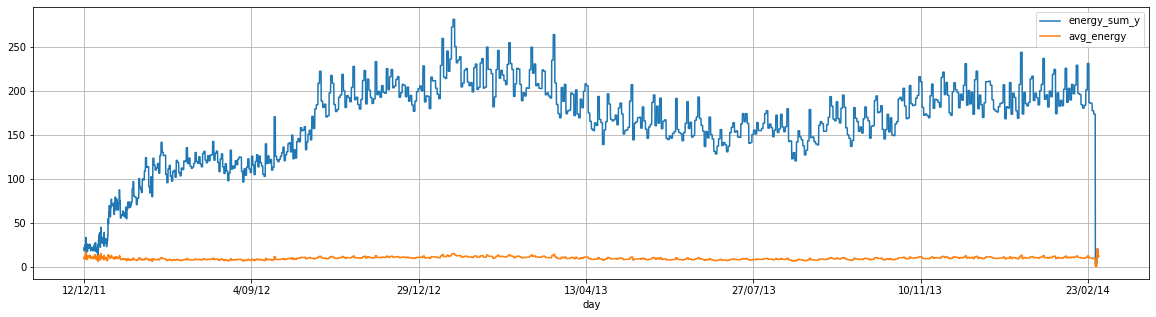

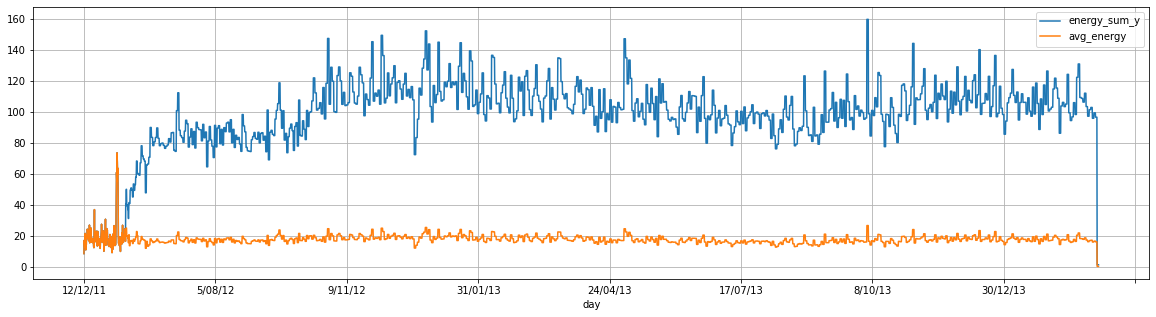

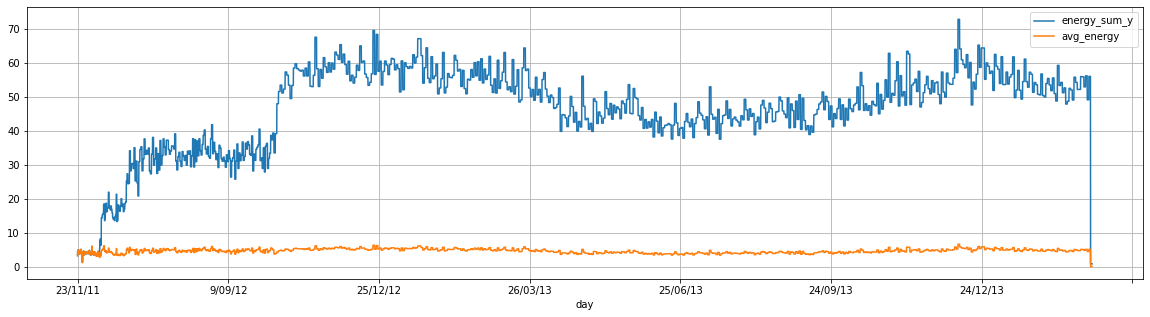

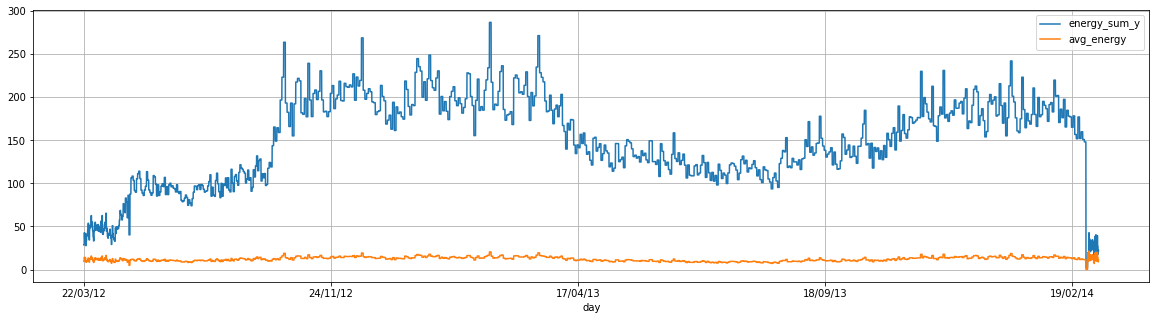

In [101]:
clus0.plot(x='day',y=['energy_sum_y','avg_energy'],figsize=(20,5),grid=1)
clus1.plot(x='day',y=['energy_sum_y','avg_energy'],figsize=(20,5),grid=1)
clus2.plot(x='day',y=['energy_sum_y','avg_energy'],figsize=(20,5),grid=1)
clus3.plot(x='day',y=['energy_sum_y','avg_energy'],figsize=(20,5),grid=1)

In [ ]:
import matplotlib.pylab as plt
%matplotlib inline

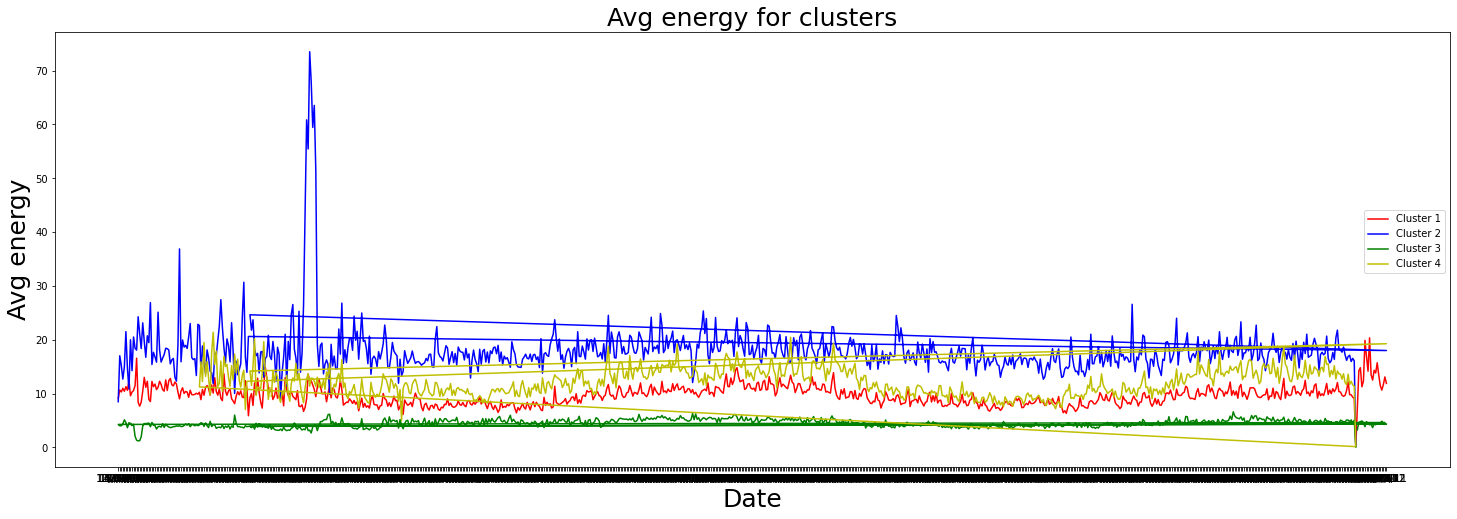

In [120]:
fig, ax1 = plt.subplots(figsize = (25,8))

plt.plot(clus0['day'],clus0['avg_energy'],c='r')
plt.plot(clus1['day'],clus1['avg_energy'],c='b')
plt.plot(clus2['day'],clus2['avg_energy'],c='g')
plt.plot(clus3['day'],clus3['avg_energy'],c='y')
plt.xlabel("Date", fontsize=25)
plt.ylabel("Avg energy", fontsize=25)
plt.title("Avg energy for clusters", fontsize=25)
plt.legend(['Cluster 1','Cluster 2','Cluster 3','Cluster 4'],bbox_to_anchor=(0.0, 0.5, 1.0, 0.102))

clus1.plot(x='day',y=['energy_sum'],figsize=(10,5))
clus2.plot(x='day',y=['energy_sum'],figsize=(10,5))

<AxesSubplot:xlabel='day'>

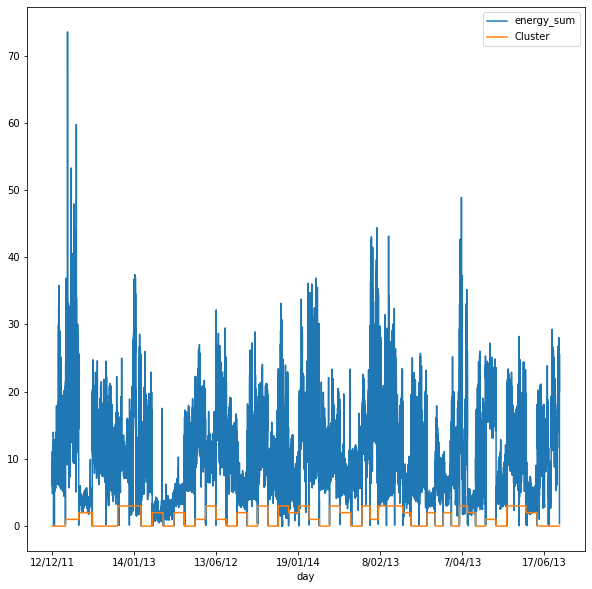

In [52]:
dk.plot(x='day',y=['energy_sum','Cluster'],figsize=(10,10))

Processing MAC000094, Cluster: 0
Processing MAC004138, Cluster: 0
Processing MAC004049, Cluster: 0
Processing MAC003868, Cluster: 0
Processing MAC003831, Cluster: 0
Processing MAC003828, Cluster: 0
Processing MAC003819, Cluster: 0
Processing MAC002311, Cluster: 0
Processing MAC005533, Cluster: 0
Processing MAC001881, Cluster: 0
Processing MAC001830, Cluster: 0
Processing MAC001792, Cluster: 0
Processing MAC002071, Cluster: 0
Processing MAC005543, Cluster: 0
Processing MAC000157, Cluster: 0
Processing MAC001592, Cluster: 0
Processing MAC001335, Cluster: 0
Processing MAC000595, Cluster: 0
Processing MAC000352, Cluster: 0
Processing MAC001626, Cluster: 0
Processing MAC003733, Cluster: 1
Processing MAC004130, Cluster: 1
Processing MAC002037, Cluster: 1
Processing MAC000097, Cluster: 1
Processing MAC001771, Cluster: 1
Processing MAC001012, Cluster: 1
Processing MAC001985, Cluster: 2
Processing MAC002245, Cluster: 2
Processing MAC005514, Cluster: 2
Processing MAC001566, Cluster: 2
Processing

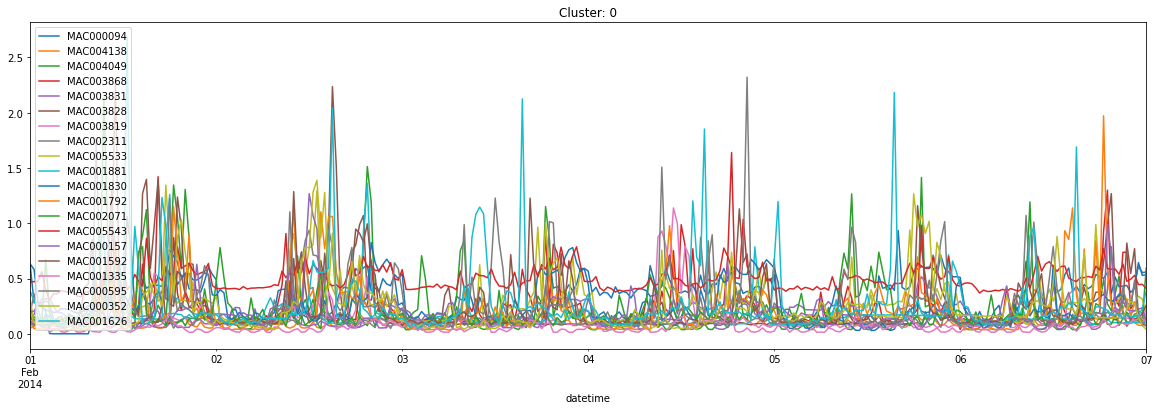

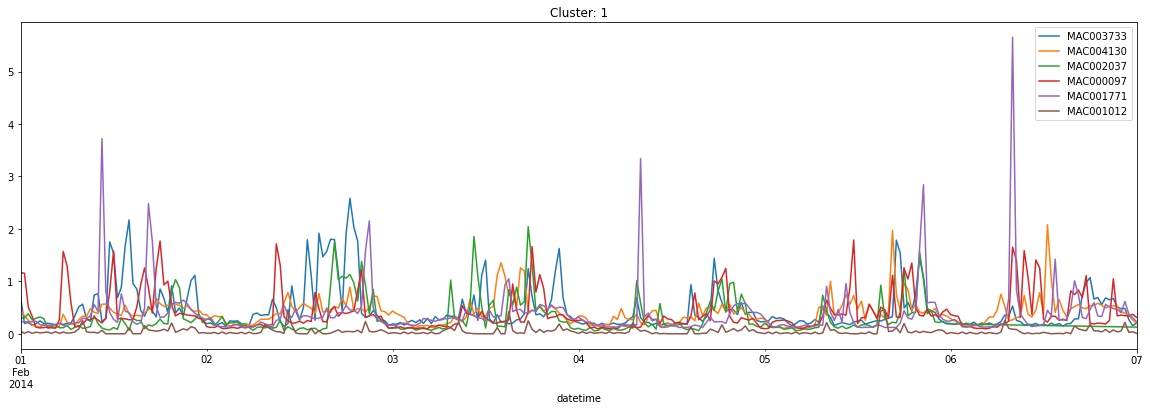

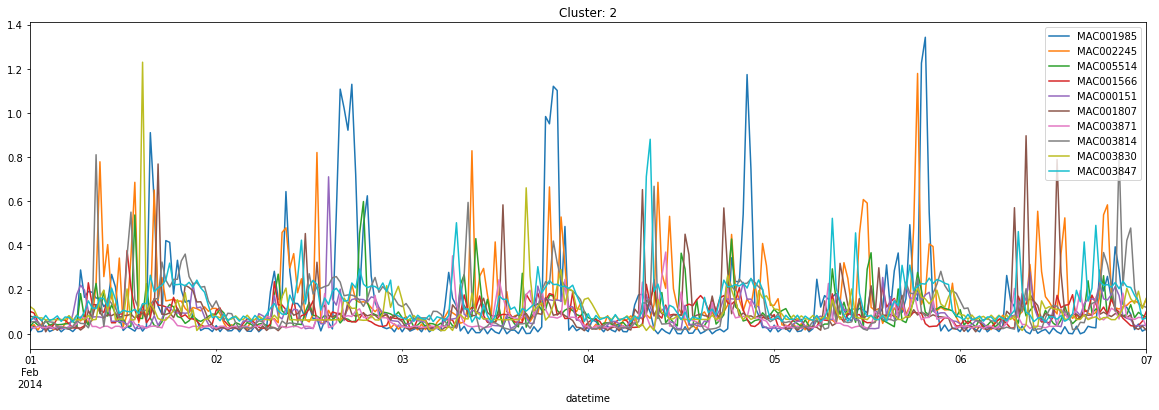

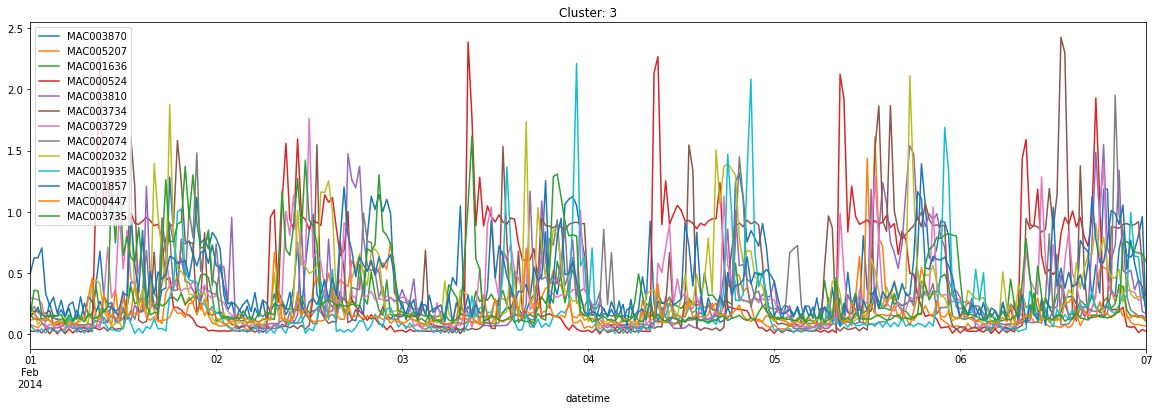

In [9]:
hourly_data = pd.read_csv('hhblock_dataset/hhblock_dataset/{}.csv'.format(block))

def create_plot(LCLid, start_date=None, end_date=None, ax=None, title=None):
    plot_data = hourly_data[(hourly_data['LCLid']==LCLid)].set_index('day').drop(columns=['LCLid'])
    plot_data = plot_data.stack().reset_index().rename(columns={0: LCLid,'level_1': 'time','day':'date'})
    plot_data['time'] = plot_data['time'].apply(lambda x: x.replace('hh_',''))
    plot_data['datetime'] = plot_data[['date','time']].apply(lambda x: pd.to_datetime(x['date'])+datetime.timedelta(minutes=int(x['time'])*30),axis=1)
    plot_data = plot_data.drop(columns=['date','time'])
    
    if start_date:
        plot_data = plot_data[(plot_data['datetime'] >= pd.to_datetime(start_date))] 
    if end_date:
        plot_data = plot_data[(plot_data['datetime'] <= pd.to_datetime(end_date))]  
        
    if len(plot_data.index>0):
        plot_data = plot_data.set_index('datetime')
        plot = plot_data.plot(ax=ax, title=title, figsize = (20,6))
        print("Processing {LCLid}, {title}".format(**{'LCLid':LCLid, 'title':title}))
        return plot
    
    print("[WARNING] LCLid: {LCLid} has no data between dates: {start_date}-> {end_date}".format(**{'LCLid': LCLid, 'start_date': start_date, 'end_date': end_date}))
    return None
    

# hourly_data.head()
ax = None
cluster = 0
start_date='2014-02-01'
end_date='2014-02-07'
title = "Cluster: {}".format(str(cluster))
for index, consumer_row in clustered_data[['LCLid','Cluster']].iterrows():
    plot_new_cluster = cluster != consumer_row['Cluster']
    consumer_id, cluster = consumer_row['LCLid'], consumer_row['Cluster']
    aux = create_plot(consumer_id,start_date=start_date,end_date=end_date,ax=ax,title=title)
    if aux:
        ax = aux
    if plot_new_cluster:
        ax = None
        title = "Cluster: {}".format(str(cluster))
